As a baseline method, I've implemented Criminsi's method for single view metrology, using distances between parallel planes. The basic procedure is as follows:

- Find vanishing points of three parallel lines from the scene, use this to establish a coordinate frame and estimate camera focal length. This gives us both the intrinsics and extrinsic rotation matrix, if we assume prior knowledge of the camera center
- Next, we select a point on the ground plane to be the world origin, and use another point, either on the ground plane or on a parallel plane, at a known distance from this origin to establish the scene scale, which nets us the extrinsic translation matrix
- We can now find the distances between either arbitrary ground plane points, or corresponding points on the ground plane and a parallel plane

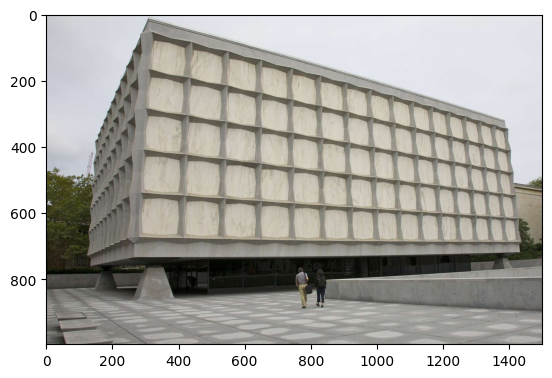

In [127]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

img = cv.imread("test3.jpg")

_ = plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

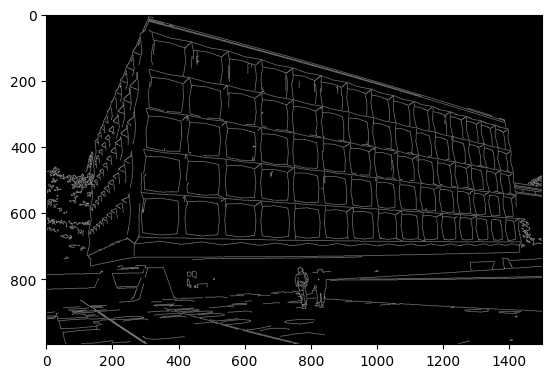

In [136]:
gray = cv.cvtColor(img.copy(), cv.COLOR_BGR2GRAY)
gray = cv.GaussianBlur(gray, (5, 5), 1)
edges = cv.Canny(gray, 50, 120)

plt.imshow(edges, cmap="gray")

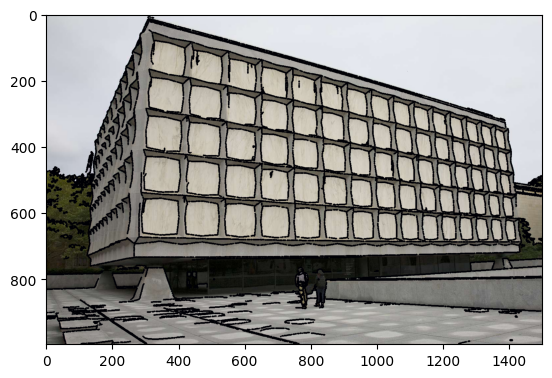

In [140]:
lines = cv.HoughLines(edges, 1, np.pi / 180, 5)

guy = img.copy()

for line in lines:
	cv.line(guy, line[0, :2], line[0, 2:], 5, 3)

plt.imshow(cv.cvtColor(guy, cv.COLOR_BGR2RGB))